In [2]:
import pandas as pd
import torch

from scipy.stats import pearsonr
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW, BertForSequenceClassification
from sklearn.metrics import mean_squared_error
from torch import nn
import warnings
warnings.filterwarnings('ignore')
import csv

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def prepare_dataset(file):
    train = []
    with open(file, mode ='r')as file:
        csvFile = csv.reader(file)
        ctr = 0
        for l in csvFile:
            if (ctr == 0):
                ctr = 1
                continue
            
            lines = ''.join(l).strip("\t").split("\t")
            if(len(lines)!=3):
                continue
            train.append({
                "score": float(lines[0].strip('"')),
                "sentence1": lines[1].strip('"'),
                "sentence2": lines[2].strip('"')
            })
            
    return train

train = prepare_dataset("train.csv")
val = prepare_dataset("dev.csv")

In [5]:
class TextSimilarityDataset(Dataset):
    
    def __init__(self, data, max_length):
        self.data = data
        self.tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sen1 = self.data[idx]['sentence1']
        sen2 = self.data[idx]['sentence2']
        score = torch.tensor(self.data[idx]["score"])

        encoding = self.tokenizer(sen1, sen2, padding="max_length", truncation=True, max_length=128, return_tensors='pt')
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "score": score
        }



In [6]:

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.model = BertModel.from_pretrained('google-bert/bert-base-uncased')
        self.fc = nn.Linear(self.model.config.hidden_size, 1)
        self.activate = nn.Tanh()
    
    def forward(self, input_ids, attention_mask):
        _, output = self.model(input_ids, attention_mask, return_dict=False)
        x = self.fc(output)
        x = self.activate(x)
        x = ((x+1)/2) * 5
        return x

In [7]:
# create a dataset class and dataloader

train_dataset = TextSimilarityDataset(train, 128)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# val dataset and dataloader
eval_dataset = TextSimilarityDataset(val, 128)
eval_loader = DataLoader(eval_dataset, batch_size=16, shuffle=True)

In [8]:
model = CustomModel()
model.to(device)

loss = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=1e-6)

In [9]:
# write a code to train the model and compute the training loss and validation loss at every epoch and store them so that I can plot it in future using matplotlib

Epoch = 5
train_plot_loss = []
val_plot_loss = []



for epoch in range(Epoch):
    
    loss_train, loss_val = 0.0, 0.0
    
    model.train()
    
    for idx, batch in enumerate(train_loader):
        
        input_ids = batch['input_ids'].to(device)

        attention_mask = batch['attention_mask'].to(device)
        score = batch['score']
        
        optimizer.zero_grad()
        
        output = model(input_ids, attention_mask).cpu()
        
        l = loss(output.squeeze(), score)
        loss_train += l.item()
        
        l.backward()
        optimizer.step()
        
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(eval_loader):
                
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            score = batch['score']
            
            output = model(input_ids, attention_mask).cpu()
            
            l = loss(output.squeeze(), score)
            loss_val += l.item()
            
    train_plot_loss.append(loss_train/len(train_loader))
    val_plot_loss.append(loss_val/len(eval_loader))
            
    print(f"Epoch {epoch+1}/{Epoch} : Train Loss : {loss_train/len(train_loader)} Val Loss : {loss_val/len(eval_loader)}")


Epoch 1/5 : Train Loss : 1.8449836358302782 Val Loss : 1.829118250490545
Epoch 2/5 : Train Loss : 1.1910091964971452 Val Loss : 1.321759397839452
Epoch 3/5 : Train Loss : 0.9114677503245885 Val Loss : 1.0878443054772995
Epoch 4/5 : Train Loss : 0.7688319354164166 Val Loss : 1.0483927864294786
Epoch 5/5 : Train Loss : 0.7112584042281997 Val Loss : 0.949855122264925


In [10]:
torch.save(model, 'model_1a.pth')

In [11]:
model = torch.load('model_1a.pth')


model.eval()

pred = []
gt = []

with torch.no_grad():
    for batch in eval_loader:
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        score = batch['score'].to(device)
        
        output = model(input_ids, attention_mask)
        pred.extend(output.squeeze().tolist())
        gt.extend(score.tolist())
        
        
# caluclate the pcc for eval set
print(f"Pearson Correlation Coefficient : {pearsonr(pred, gt)[0]}")
        

Pearson Correlation Coefficient : 0.7821289775277269


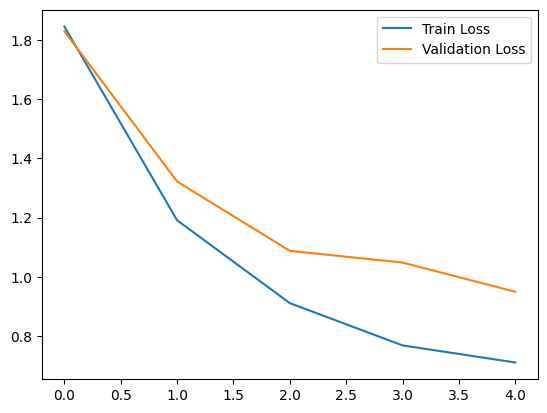

In [12]:
import matplotlib.pyplot as plt

plt.plot(train_plot_loss, label='Train Loss')
plt.plot(val_plot_loss, label='Validation Loss')
plt.legend()
plt.show()

In [14]:
torch.save(model,"model_1a.pth")